Within scikit-learn, pipelines allow for the consolidation of all data preprocessing steps 
along with a final estimator using a single interface. The pipeline object can then
be passed into a grid search routine to identify optimal hyperparameters. According to the 
documentation, the purpose of the pipeline is to assemble several steps that can be 
cross-validated together while setting different parameters. In this post, we'll demonstrate
how to utilize pipelines to preprocess the adult income data set and fit two classifiers
to determine whether a given observation has an income in excess of $50,000 given the set
of associated features. We first read in the data and inspect the first few records:

In [1]:

from itertools import zip_longest
import os
import sys
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, 
    confusion_matrix, precision_recall_curve, roc_curve
    )
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.set_printoptions(suppress=True, precision=8)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)

train_path = "https://gist.githubusercontent.com/jtrive84/13d05ace37948cac9583a9ab1f2def31/raw/3dc5bc9e0b573c1039abc20f816321e570aae69c/adult.csv"
dftrain = pd.read_csv(train_path)

print(dftrain.head())


   age  workclass  fnlwgt     education  educational-num      marital-status         occupation relationship   race  gender  capital-gain  capital-loss  hours-per-week native-country income
0   25    Private  226802          11th                7       Never-married  Machine-op-inspct    Own-child  Black    Male             0             0              40  United-States  <=50K
1   38    Private   89814       HS-grad                9  Married-civ-spouse    Farming-fishing      Husband  White    Male             0             0              50  United-States  <=50K
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse    Protective-serv      Husband  White    Male             0             0              40  United-States   >50K
3   44    Private  160323  Some-college               10  Married-civ-spouse  Machine-op-inspct      Husband  Black    Male          7688             0              40  United-States   >50K
4   18          ?  103497  Some-college           

After loading the dataset, the first task is to get an idea of the frequency of different 
groups within categorical features. In the next cell, a dictionary is created for each categorical feature which 
remaps groups to ensure a reasonable number of observations in each:

In [3]:

dworkclass = {
    "Federal-gov": "gov",
    "Local-gov": "gov",          
    "Never-worked": "other",    
    "Private": "private",
    "Self-emp-inc": "other",
    "Self-emp-not-inc": "other", 
    "State-gov": "gov", 
    "Without-pay": "other",
    "missing": "missing"
    }

deducation = {
    "Preschool": "no-hs",        
    "1st-4th": "no-hs",     
    "5th-6th": "no-hs",  
    "7th-8th": "no-hs",  
    "9th": "hs",         
    "10th": "hs",               
    "11th": "hs",            
    "12th": "hs",                 
    "HS-grad": "hs-grad",
    "Prof-school": "some-college",
    "Some-college": "some-college",
    "Assoc-acdm": "some-college", 
    "Assoc-voc": "some-college",   
    "Bachelors": "bachelors",    
    "Masters": "masters",    
    "Doctorate": "phd",   
    "missing": "missing"
    }

dmarital = {
    "Divorced": "divorced",  
    "Married-AF-spouse": "married", 
    "Married-civ-spouse": "married", 
    "Married-spouse-absent": "married", 
    "Never-married": "not-married", 
    "Separated": "divorced", 
    "Widowed": "widowed", 
    "missing": "missing"
    }

doccupation = {
    "Adm-clerical":  "clerical", 
    "Armed-Forces": "other",          
    "Craft-repair": "repair",         
    "Exec-managerial": "managerial",   
    "Farming-fishing": "farming",     
    "Handlers-cleaners": "cleaners",  
    "Machine-op-inspct": "repair",    
    "Other-service": "service",  
    "Priv-house-serv": "other",
    "Prof-specialty": "specialty",
    "Protective-serv": "other",
    "Sales": "sales", 
    "Tech-support": "tech", 
    "Transport-moving": "moving",
    "missing": "missing"
    }

doccupation2 = {
    "Adm-clerical":  "white", 
    "Armed-Forces": "other", 
    "Craft-repair": "blue",  
    "Exec-managerial": "white",
    "Farming-fishing": "blue", 
    "Handlers-cleaners": "blue", 
    "Machine-op-inspct": "blue", 
    "Other-service": "blue", 
    "Priv-house-serv": "other", 
    "Prof-specialty": "other", 
    "Protective-serv": "blue",
    "Sales": "white",  
    "Tech-support": "white",
    "Transport-moving": "blue",  
    "missing": "missing"
    }

drelationship = {
    "Husband": "husband",  
    "Not-in-family": "no-family", 
    "Other-relative": "other",  
    "Own-child": "child",      
    "Unmarried": "unmarried",  
    "Wife": "wife", 
    "missing": "missing"
    }

drace = {
    "Amer-Indian-Eskimo": "eskimo",
    "Asian-Pac-Islander": "asian", 
    "Black": "black", 
    "Other": "other",
    "White": "white",
    "missing": "missing"
    }

dgender = {
    "Female": "F",
    "Male": "M",
    "missing": "missing"
    }


Next we distinguish between categorical and continuous features. 
Categorical features are re-mapped to align with the groups defined above. For categorical
features, we assign null values to a "missing" category instead of relying on an imputation
rule. This allows us to check for possible patterns in the missing data later on. 
`capital-gain` and `capital-loss` are converted into binary indicators and `native-country`
into US vs. non-US.  Finally, we split the data into training and validation sets ensuring
the same proportion of positive instances in each cut:

In [4]:

categorical = [
    "workclass", "marital-status", "occupation", "relationship",
    "race", "gender", "capital-gain", "capital-loss", "native-country"
    ]

continuous = [
    "fnlwgt", "hours-per-week", "age", "educational-num"
    ]

# workclass.
dftrain["workclass"] = dftrain["workclass"].fillna("missing")
dftrain["workclass"] = dftrain["workclass"].map(dworkclass)

# marital-status.
dftrain["marital-status"] = dftrain["marital-status"].fillna("missing")
dftrain["marital-status"] = dftrain["marital-status"].map(dmarital)

# occupation.
dftrain["occupation"] = dftrain["occupation"].fillna("missing")
dftrain["occupation"] = dftrain["occupation"].map(doccupation)

# relationship.
dftrain["relationship"] = dftrain["relationship"].fillna("missing")
dftrain["relationship"] = dftrain["relationship"].map(drelationship)

# race.
dftrain["race"] = dftrain["race"].fillna("missing")
dftrain["race"] = dftrain["race"].map(drace)

# sex.
dftrain["gender"] = dftrain["gender"].fillna("missing")
dftrain["gender"] = dftrain["gender"].map(dgender)

# capital-gain: Convert to binary indicator. 
dftrain["capital-gain"] = dftrain["capital-gain"].map(lambda v: 1 if v > 0 else 0)

# capital-loss: Convert to binary indicator. 
dftrain["capital-loss"] = dftrain["capital-loss"].map(lambda v: 1 if v > 0 else 0)

# Encode native-country.
dftrain["native-country"] = dftrain["native-country"].map(lambda v: "US" if v == "United-States" else "other")

# Encode response.
dftrain["income"] = dftrain["income"].map(lambda v: 1 if v == ">50K" else 0)

# Create train and validation sets. 
y = dftrain["income"]
dft, dfv, yt, yv = train_test_split(dftrain, y, test_size=.125, stratify=y)

print(f"dft.shape: {dft.shape}")
print(f"dfv.shape: {dfv.shape}")
print(f"prop. yt : {yt.sum() / dft.shape[0]:.4f}")
print(f"prop. yv : {yv.sum() / dfv.shape[0]:.4f}")


dft.shape: (42736, 15)
dfv.shape: (6106, 15)
prop. yt : 0.2393
prop. yv : 0.2393


With categorical features re-mapped, it is useful to look at the proportion of positive instances
in each group per feature:

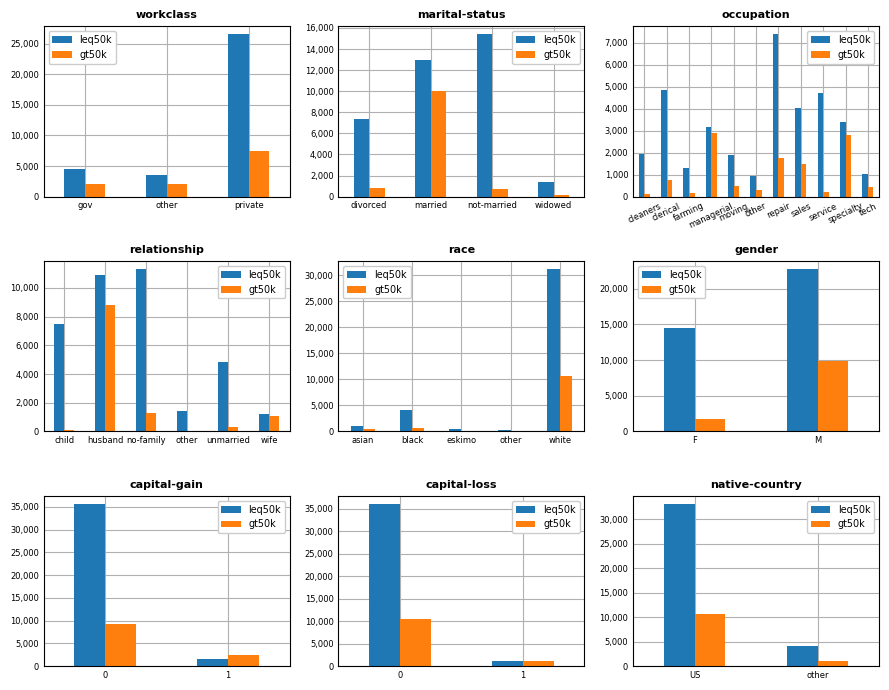

In [5]:

indices = [
    (0, 0), (0, 1), (0, 2), 
    (1, 0), (1, 1), (1, 2),
    (2, 0), (2, 1), (2, 2), 
    ]

fig, ax = plt.subplots(3, 3, figsize=(9, 7), tight_layout=True) 

for (ii, jj), col in zip_longest(indices, categorical):

    if col is None:
        ax[ii, jj].remove()
    else:
        gg = dftrain.groupby(col, as_index=False).agg(
            leq50k=("income", lambda v: v[v==0].size),
            gt50k=("income", "sum")
            ).sort_values(col, ascending=True)
        
        if col in ["education-num", "capital-gain", "capital-loss"]:
            gg[col] = gg[col].astype(str)

        if col == "occupation":
            rot = 25
        else:
            rot = 0

        gg.plot.bar(ax=ax[ii, jj])
        ax[ii, jj].set_title(col, fontsize=8, weight="bold")
        ax[ii, jj].set_xticklabels(gg[col].values, rotation=rot)
        ax[ii, jj].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
        ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
        ax[ii, jj].tick_params(axis="x", which="minor", direction='in', labelsize=6)
        ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
        ax[ii, jj].tick_params(axis="y", which="minor", direction='in', labelsize=6)
        ax[ii, jj].xaxis.set_ticks_position("none")
        ax[ii, jj].yaxis.set_ticks_position("none")
        ax[ii, jj].legend(loc="best", fancybox=True, framealpha=1, fontsize="x-small")
        ax[ii, jj].grid(True)   
        ax[ii, jj].set_axisbelow(True) 

plt.show()


From the generated plot, we take-away the following:

- `education-num`: Higher percentage of ">50k" for levels >= 13. 
- `maritial-status`: Higher proportion of ">50k" for married vs. all other groups. 
- `sex`: Higher proportion of ">50k" for Males vs. Females.
- `occupation`: Higher proportion of ">50k"  for managerial and specialty.


A similar exhibit for continuous features gives us an idea of the distribution of values in each:

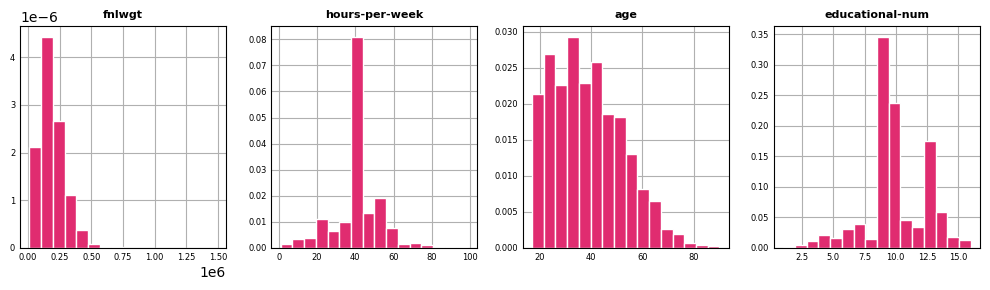

In [6]:

indices = [0, 1, 2, 3]

fig, ax = plt.subplots(1, 4, figsize=(10, 3), tight_layout=True) 

for ii, col in zip_longest(indices, continuous):
    ax[ii].set_title(col, fontsize=8, weight="bold")
    ax[ii].hist(
        dft[col], 16, density=True, alpha=1, color="#E02C70", 
        edgecolor="#FFFFFF", linewidth=1.0
        )
    #ax[ii].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="x", which="minor", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii].tick_params(axis="y", which="minor", direction='in', labelsize=6)
    ax[ii].xaxis.set_ticks_position("none")
    ax[ii].yaxis.set_ticks_position("none")
    # ax[ii].legend(loc="best", fancybox=True, framealpha=1, fontsize="x-small")
    ax[ii].grid(True)   
    ax[ii].set_axisbelow(True) 

plt.show()



We are now in a position to create our pipelines. The first pipeline is created to support a logistic regression classifier. We initialize a `ColumnTransformer`
instance, which gives us the ability to define separate preprocessing steps for different groups of columns (in our case, categorical vs. continuous). As the logistic regression classifier doesn't support categorical features, we one-hot encode them. In addition, since the logistic regression classifier relies on gradient descent to estimate coefficients, continuous features are scaled using `RobustScaler` to help with convergence and missing values imputed using `IterativeImputer`. For the classifier, we use the elasticnet penalty, which is a blend of lasso and ridge penalties. We'll determine the optimal weighting using grid search. 

In [7]:
from sklearn.linear_model import LogisticRegression

# Data pre-processing for LogisticRegression model.
lr = LogisticRegression(
    penalty="elasticnet", solver="saga", max_iter=5000
    )
continuous_transformer1 = Pipeline(steps=[
    ("imputer", IterativeImputer()),
    ("scaler" , RobustScaler())
    ])
categorical_transformer1 = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="error"))
    ])
preprocessor1 = ColumnTransformer(transformers=[
    ("continuous" , continuous_transformer1, continuous),  
    ("categorical", categorical_transformer1, categorical)
    ], remainder="drop"
    )
pipeline1 = Pipeline(steps=[
    ("preprocessor", preprocessor1),
    ("classifier", lr)
    ]).set_output(transform="pandas")



Notice that `set_output` is affixed to `pipeline1` by specifying `transform="pandas"`. This was 
added in scikit-learn version 1.2, and allows intermediate and final datasets to be represented 
as Pandas DataFrames instead of Numpy arrays. I've found this to be particularly convenient, 
especially when inspecting the results of a transformation. 

A different set of preprocessing steps is carried out for the HistGradientBoostingClassifier
instance, which is functionally equivalent to lightgbm. Since HistGradientBoostingClassifier 
supports categorical features, it isn't necessary to one-hot encode: We pass a list of 
columns that should be treated as nominal categorical features to the `categorical_features` parameter. 
Coming out of `ColumnTransformer`, categorical features are renamed with a leading `categorical__`, so 
it is easy to identify which columns to pass. As before, `IterativeImputer` is used to impute missing 
continuous values. Within `categorical_transformer2`, we pass `OrdinalEncoder` to convert non-numeric 
categories to integers, which can then be processed by HistGradientBoostingClassifier. Since 
HistGradientBoostingClassifier doesn't rely on gradient descent, it isn't necessary to include 
`RobustScaler`in `continuous_transformer2`.


In [8]:

from sklearn.ensemble import HistGradientBoostingClassifier

# Data pre-processing for HistGradientBoostingClassifier model. Uses OrdinalEncoder
# instead of OneHotEncoder since categorical features are supported.     
gb = HistGradientBoostingClassifier(
    categorical_features=[f"categorical__{ii}" for ii in categorical]
    )
continuous_transformer2 = Pipeline(steps=[
    ("imputer", IterativeImputer())
    ])
categorical_transformer2 = Pipeline(steps=[
    ("encoder", OrdinalEncoder())
    ])
preprocessor2 = ColumnTransformer(transformers=[
    ("continuous" , continuous_transformer2, continuous), 
    ("categorical", categorical_transformer2, categorical),
    ], remainder="drop"
    )
pipeline2 = Pipeline(steps=[
    ("preprocessor", preprocessor2), 
    ("classifier", gb)
    ]).set_output(transform="pandas")



Instead og using `GridSearchCV`, we leverage `RandomizedSearchCV`. `GridSearchCV` evaluates a multi-dimensional array of hyperparameters, whereas `RandomizedSearchCV` samples from a pre-specified distribution a defined number of samples. For our logistic regression classifier, we sample uniformly from [0, 1] for `l1_ratio` and [0, 10] for the regularization parameter `C`. 

In [16]:

from scipy.stats import uniform

RANDOM_STATE = 516
verbosity = 3
n_iter = 3
scoring = "accuracy"
cv = 5

param_grid1 = {
    "classifier__l1_ratio": uniform(loc=0, scale=1), 
    "classifier__C": uniform(loc=0, scale=10)
    }

mdl1 = RandomizedSearchCV(
    pipeline1, param_grid1, scoring=scoring, cv=cv, verbose=verbosity, 
    random_state=RANDOM_STATE, n_iter=n_iter
    )

mdl1.fit(dft.drop("income", axis=1), yt)

print(f"\nbest parameters: {mdl1.best_params_}")

# Get holdout scores for each fold to compare against other model.
best_rank1 = np.argmin(mdl1.cv_results_["rank_test_score"])
best_mdl_cv_scores1 = [
    mdl1.cv_results_[f"split{ii}_test_score"][best_rank1] for ii in range(cv)
    ]


dfv["ypred1"] = mdl1.predict_proba(dfv.drop("income", axis=1))[:, 1]
dfv["yhat1"] = dfv["ypred1"].map(lambda v: 1 if v >= .50 else 0)

mdl1_acc = accuracy_score(dfv["income"], dfv["yhat1"])
mdl1_precision = precision_score(dfv["income"], dfv["yhat1"])
mdl1_recall = recall_score(dfv["income"], dfv["yhat1"])

print(f"\nmdl1_acc      : {mdl1_acc}")
print(f"mdl1_precision: {mdl1_precision}")
print(f"mdl1_recall   : {mdl1_recall}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__C=8.115660497752215, classifier__l1_ratio=0.7084090612742915;, score=0.841 total time=   2.3s
[CV 2/5] END classifier__C=8.115660497752215, classifier__l1_ratio=0.7084090612742915;, score=0.840 total time=   1.7s
[CV 3/5] END classifier__C=8.115660497752215, classifier__l1_ratio=0.7084090612742915;, score=0.843 total time=   2.6s
[CV 4/5] END classifier__C=8.115660497752215, classifier__l1_ratio=0.7084090612742915;, score=0.843 total time=   1.8s
[CV 5/5] END classifier__C=8.115660497752215, classifier__l1_ratio=0.7084090612742915;, score=0.850 total time=   1.7s
[CV 1/5] END classifier__C=1.115284252761577, classifier__l1_ratio=0.5667878644753359;, score=0.841 total time=   1.6s
[CV 2/5] END classifier__C=1.115284252761577, classifier__l1_ratio=0.5667878644753359;, score=0.840 total time=   1.5s
[CV 3/5] END classifier__C=1.115284252761577, classifier__l1_ratio=0.5667878644753359;, score=0.843 total t

We proceed analogously for HistGradientBoostingClassifier, but sample from different hyperparameters. 

In [17]:

RANDOM_STATE = 516
scoring = "accuracy"
verbosity = 3
n_iter = 3
cv = 5


param_grid2 = {
    "classifier__max_iter": [100, 250, 500],
    "classifier__min_samples_leaf": [10, 20, 50, 100],
    "classifier__l2_regularization": uniform(loc=0, scale=1000),
    "classifier__learning_rate": [.01, .05, .1, .25, .5],
    "classifier__max_leaf_nodes": [None, 20, 31, 40, 50]
    }

mdl2 = RandomizedSearchCV(
    pipeline2, param_grid2, scoring=scoring, cv=cv, verbose=verbosity, 
    random_state=RANDOM_STATE, n_iter=n_iter
    )

mdl2.fit(dft.drop("income", axis=1), yt)

print(f"\nbest parameters: {mdl2.best_params_}")

# Get holdout scores for each fold to compare against other model.
best_rank2 = np.argmin(mdl2.cv_results_["rank_test_score"])
best_mdl_cv_scores2 = [
    mdl2.cv_results_[f"split{ii}_test_score"][best_rank2] for ii in range(cv)
    ]

dfv["ypred2"] = mdl2.predict_proba(dfv.drop("income", axis=1))[:, 1]
dfv["yhat2"] = dfv["ypred2"].map(lambda v: 1 if v >= .50 else 0)


mdl2_acc = accuracy_score(dfv["income"], dfv["yhat2"])
mdl2_precision = precision_score(dfv["income"], dfv["yhat2"])
mdl2_recall = recall_score(dfv["income"], dfv["yhat2"])

print(f"\nmdl2_acc      : {mdl2_acc}")
print(f"mdl2_precision: {mdl2_precision}")
print(f"mdl2_recall   : {mdl2_recall}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__l2_regularization=811.5660497752214, classifier__learning_rate=0.25, classifier__max_iter=500, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=50;, score=0.846 total time=   1.1s
[CV 2/5] END classifier__l2_regularization=811.5660497752214, classifier__learning_rate=0.25, classifier__max_iter=500, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=50;, score=0.848 total time=   1.5s
[CV 3/5] END classifier__l2_regularization=811.5660497752214, classifier__learning_rate=0.25, classifier__max_iter=500, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=50;, score=0.849 total time=   1.1s
[CV 4/5] END classifier__l2_regularization=811.5660497752214, classifier__learning_rate=0.25, classifier__max_iter=500, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=50;, score=0.849 total time=   0.9s
[CV 5/5] END classifier__l2_regularization=811.5660497752214, classi

Notice that `mdl1` and `mdl2` expose `predict/predict_proba` methods, so we can generate predictions using the resulting `RandomizedSearchCV` object directly, and it will dispatch a call to the estimator associated with the hyperparameters that maximize accuracy. 

Precision, recall and accuracy are close for each model. We can check if the difference between models is significant using the approach outlined [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#comparing-two-models-frequentist-approach):


In [18]:

from scipy.stats import t

def corrected_std(differences, n_train, n_test):
    """
    Corrects standard deviation using Nadeau and Bengio's approach.
    """
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return(corrected_std)


def compute_corrected_ttest(differences, df, n_train, n_test):
    """
    Computes right-tailed paired t-test with corrected variance.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return(t_stat, p_val)


differences = np.asarray(best_mdl_cv_scores2) - np.asarray(best_mdl_cv_scores1)
n = len(differences)
df = n - 1
n_train = 4 * (dft.shape[0] // 5) 
n_test = dft.shape[0] // 5

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)

print(f"t-value: {t_stat:.3f}")
print(f"p-value: {p_val:.3f}")


t-value: 5.231
p-value: 0.003


At a significance alpha level at p=0.05, the test concludes that HistGradientBoostingClassifier is significantly better than the LogisticRegression model. 

Finally, we can overlay the histograms of model predictions by true class:

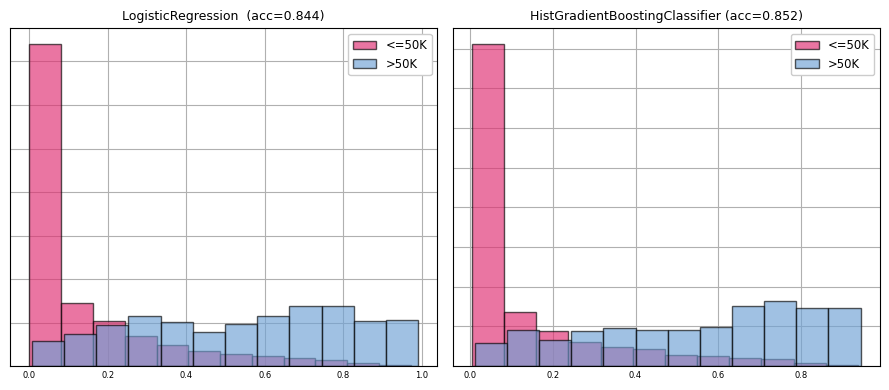

In [19]:

color0 = "#E02C70"
color1 = "#6EA1D5"
alpha = .65
n_bins = 12

fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True) 

# LogisticRegression.
yy0 = dfv[dfv.income==0]["ypred1"].values
yy1 = dfv[dfv.income==1]["ypred1"].values
ax[0].set_title(
    f"LogisticRegression  (acc={mdl1_acc:.3f})", 
    fontsize=9, weight="normal"
    )
ax[0].hist(
    yy0, n_bins, density=True, alpha=alpha, color=color0, 
    edgecolor="#000000", linewidth=1.0, label="<=50K"
    )
ax[0].hist(
    yy1, n_bins, density=True, alpha=alpha, color=color1,
    edgecolor="#000000", linewidth=1.0, label=">50K"
    )
ax[0].tick_params(axis="x", which="major", direction='in', labelsize=6)
ax[0].tick_params(axis="x", which="minor", direction='in', labelsize=6)
ax[0].tick_params(axis="y", which="major", direction='in', labelsize=6)
ax[0].tick_params(axis="y", which="minor", direction='in', labelsize=6)
ax[0].xaxis.set_ticks_position("none")
ax[0].yaxis.set_ticks_position("none")
ax[0].set_yticklabels([])
ax[0].legend(loc="best", fancybox=True, framealpha=1, fontsize="small")
ax[0].grid(True)   
ax[0].set_axisbelow(True) 

# HistGradientBoostingClassifier.
yy0 = dfv[dfv.income==0]["ypred2"].values
yy1 = dfv[dfv.income==1]["ypred2"].values
ax[1].set_title(
    f"HistGradientBoostingClassifier (acc={mdl2_acc:.3f})", 
    fontsize=9, weight="normal"
    )
ax[1].hist(
    yy0, n_bins, density=True, alpha=alpha, color=color0, 
    edgecolor="#000000", linewidth=1.0, label="<=50K"
    )
ax[1].hist(
    yy1, n_bins, density=True, alpha=alpha, color=color1,
    edgecolor="#000000", linewidth=1.0, label=">50K"
    )
ax[1].tick_params(axis="x", which="major", direction='in', labelsize=6)
ax[1].tick_params(axis="x", which="minor", direction='in', labelsize=6)
ax[1].tick_params(axis="y", which="major", direction='in', labelsize=6)
ax[1].tick_params(axis="y", which="minor", direction='in', labelsize=6)
ax[1].xaxis.set_ticks_position("none")
ax[1].yaxis.set_ticks_position("none")
ax[1].set_yticklabels([])
ax[1].legend(loc="best", fancybox=True, framealpha=1, fontsize="small")
ax[1].grid(True)   
ax[1].set_axisbelow(True) 

plt.show()
